In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from rumboost.rumboost import rum_train
from rumboost.datasets import load_preprocess_LPMC
from rumboost.utility_plotting import plot_ind_spec_constant 
from rumboost.metrics import cross_entropy
from rumboost.post_process import split_fe_model

import lightgbm

# Example: Functional effect model (correlation amongst observations)

This notebook shows features implemented in RUMBoost through an example on the LPMC dataset, a mode choice dataset in London developed Hillel et al. (2018). You can find the original source of data [here](https://www.icevirtuallibrary.com/doi/suppl/10.1680/jsmic.17.00018) and the original paper [here](https://www.icevirtuallibrary.com/doi/full/10.1680/jsmic.17.00018).

We first load the preprocessed dataset and its folds for cross-validation. You can find the data under the Data folder

In [4]:
#load dataset
LPMC_train, LPMC_test, folds = load_preprocess_LPMC()

## Functional effect model

We present the functional effect model, inspired from the Mixed Effect models. We create two ensembles per alternative where one contains the attributes with no interaction, and another one contains the socio-economic characteristics, with no interaction restrictions. The only thing that needs to be updated is the ```rum_structure``` dictionary where there are now ```2*num_classes``` dictionaries in the list. The ensembles can have different boosting parameters, which is useful to apply regularisation parameters to the esnembles with full interactions.

In [5]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": 4,  # important
    "verbosity": 1,  # specific RUMBoost parameter
    "num_iterations": 3000,
    "early_stopping_round": 100,
    "max_booster_to_update": 8,
}

In [6]:
rum_structure = [
    {
        "utility": [0],
        "variables": [
            "distance",
            "dur_walking",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
            ],
        },
        "shared": False,
    },
    {
        "utility": [0],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
            ],
        },
        "shared": False,
    },
    {
        "utility": [1],
        "variables": [
            "distance",
            "dur_cycling",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
            ],
        },
        "shared": False,
    },
    {
        "utility": [1],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
            ],
        },
        "shared": False,
    },
    {
        "utility": [2],
        "variables": [
            "distance",
            "dur_pt_access",
            "dur_pt_bus",
            "dur_pt_rail",
            "dur_pt_int_waiting",
            "dur_pt_int_walking",
            "pt_n_interchanges",
            "cost_transit",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
                [2],
                [3],
                [4],
                [5],
                [6],
                [7],
            ],
        },
        "shared": False,
    },
    {
        "utility": [2],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
            ],
        },
        "shared": False,
    },
    {
        "utility": [3],
        "variables": [
            "distance",
            "dur_driving",
            "cost_driving_fuel",
            "congestion_charge",
            "driving_traffic_percent",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "max_depth": 1,
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                -1,
                -1,
                -1,
                -1,
                -1,
            ],
            "interaction_constraints": [
                [0],
                [1],
                [2],
                [3],
                [4],
            ],
        },
        "shared": False,
    },
    {
        "utility": [3],
        "variables": [
            "age",
            "female",
            "day_of_week",
            "start_time_linear",
            "car_ownership",
            "driving_license",
            "purpose_B",
            "purpose_HBE",
            "purpose_HBO",
            "purpose_HBW",
            "purpose_NHBO",
            "fueltype_Average",
            "fueltype_Diesel",
            "fueltype_Hybrid",
            "fueltype_Petrol",
        ],
        "boosting_params": {
            "monotone_constraints_method": "advanced",
            "n_jobs": -1,
            "learning_rate": 0.1,
            "monotone_constraints": [
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
            ],
        },
        "shared": False,
    },
]

In [7]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

### Hyperparameter search

We need to regularise the part of the model with full interactions. Therefore we can conduct a hyperparameter search with hyperopt (mode details [here](https://hyperopt.github.io/hyperopt/).).
For computational reasons, we will only run the model hyperparameter search for one iteration.

In [8]:
#features and label column names
features = [f for f in LPMC_train.columns if f != "choice"]
label = "choice"

#create lightgbm dataset
lgb_train_set = lightgbm.Dataset(LPMC_train[features], label=LPMC_train[label], free_raw_data=False)
lgb_test_set = lightgbm.Dataset(LPMC_test[features], label=LPMC_test[label], free_raw_data=False)

In [9]:
import hyperopt

_, _, folds = load_preprocess_LPMC()

param_space =  {'learning_rate': hyperopt.hp.choice('learning_rate', [0.1]),
                'num_leaves': hyperopt.pyll.scope.int(hyperopt.hp.quniform('num_leaves', 2, 100, 1)),
                'min_gain_to_split':  hyperopt.hp.loguniform('min_gain_to_split', -9.21, 1.61), # interval: [0.0001, 5]
                'min_sum_hessian_in_leaf': hyperopt.hp.loguniform('min_sum_hessian_in_leaf', 0, 4.6),
                'min_data_in_leaf': hyperopt.pyll.scope.int(hyperopt.hp.quniform('min_data_in_leaf', 1, 200, 1)),
                'bagging_fraction': hyperopt.hp.uniform('bagging_fraction', 0.5, 1),
                'bagging_freq': hyperopt.hp.choice('bagging_freq', [0, 1, 5, 10]),
                'feature_fraction': hyperopt.hp.uniform('feature_fraction', 0.5, 1),
                'lambda_l1': hyperopt.hp.loguniform('lambda_l1', -9.21, 2.30), # interval: [0.0001, 10]
                'lambda_l2': hyperopt.hp.loguniform('lambda_l2', -9.21, 2.30), # interval: [0.0001, 10]
                'max_bin': hyperopt.pyll.scope.int(hyperopt.hp.quniform('max_bin', 100, 500, 1))
                            }

def objective(space):
    
    for i, dict in enumerate(model_specification['rum_structure']):
        if i%2 == 1:
            dict["boosting_params"].update(space)

    ce_loss = 0
    num_trees = 0

    for train_idx, test_idx in folds:
        train_set = lgb_train_set.subset(sorted(train_idx))
        test_set = lgb_train_set.subset(sorted(test_idx))

        LPMC_model_trained = rum_train(train_set, model_specification, valid_sets=[test_set])

        ce_loss += LPMC_model_trained.best_score
        num_trees += LPMC_model_trained.best_iteration


    ce_loss = ce_loss / 5
    num_trees = num_trees / 5

    return {'loss': ce_loss, 'status': hyperopt.STATUS_OK, 'best_iteration': num_trees}


#%%
#n_iter = 100
n_iter = 1

trials = hyperopt.Trials()
best_classifier = hyperopt.fmin(fn=objective,
                                space=param_space,
                                algo=hyperopt.tpe.suggest,
                                max_evals=n_iter,
                                trials=trials)

print(f'Best negative CE: {trials.best_trial["result"]["loss"]}')


[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510                     
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338                     
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]------NCE value on train set : 1.2381             
---------NCE value on test set 1: 1.2400             
[11]-----NCE value on train set : 0.8056             
---------NCE value on test set 1: 0.8184             
[21]-----NCE value on train set : 0.7224             
---------NCE value on test set 1: 0.7382             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]-----NCE value on train set : 0.6871             
---------NCE value on test set 1: 0.7070             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510                     
[LightGBM] [Info] Number of data points in the train set: 43813, number of used features: 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335                     
[LightGBM] [Info] Number of data points in the train set: 43813, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484                    
[LightGBM] [Info] Number of data points in the train set: 43813, number of used features: 8
[LightGBM] 

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1483                    
[LightGBM] [Info] Number of data points in the train set: 43814, number of used features: 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 336                     
[LightGBM] [Info] Number of data points in the train set: 43814, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022                    
[LightGBM] [Info] Number of data points

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1482                    
[LightGBM] [Info] Number of data points in the train set: 43815, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336                     
[LightGBM] [Info] Number of data points in the train set: 43815, number of used features: 15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022                    
[LightGBM] [Info] Number of data points

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510                     
[LightGBM] [Info] Number of data points in the train set: 43810, number of used features: 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337                     
[LightGBM] [Info] Number of data points in the train set: 43810, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

### Cross-validation with already computed optimal hyperparameters

We have the optimal hyperparameters (taken from a previous run), so we run a final 5-fold cross validation to obtain the optimal number of trees.

In [10]:
_, _, folds = load_preprocess_LPMC()

optimal_params_fe = {'learning_rate':0.1,
                'num_leaves': 74,
                'min_gain_to_split': 0.8003177141507178,
                'min_sum_hessian_in_leaf': 1.7832435538908582,
                'min_data_in_leaf': 27,
                'bagging_fraction': 0.7002428082063967,
                'bagging_freq': 10,
                'feature_fraction': 0.8666540515437967,
                'lambda_l1': 6.591757385667399,
                'lambda_l2': 1.027567442472481,
                'max_bin': 131
                            }

ce_loss = 0
num_trees = 0

for i, dict in enumerate(model_specification['rum_structure']):
    if i%2 == 1:
        dict["boosting_params"].update(optimal_params_fe)

for i, (train_idx, test_idx) in enumerate(folds):
    #train and validation set
    train_set = lgb_train_set.subset(sorted(train_idx))
    test_set = lgb_train_set.subset(sorted(test_idx))

    print('-'*50 + '\n')
    print(f'Iteration {i+1}')

    #train model with functional effect parameters
    LPMC_model_trained = rum_train(train_set, model_specification, valid_sets=[test_set])

    #aggregate results
    ce_loss += LPMC_model_trained.best_score
    num_trees += LPMC_model_trained.best_iteration
    
    print('-'*50 + '\n')
    print(f'Best cross entropy loss: {LPMC_model_trained.best_score}')
    print(f'Best number of trees: {LPMC_model_trained.best_iteration}')

ce_loss = ce_loss/5
num_trees = num_trees/5
print('-'*50 + '\n')
print(f'Cross validation negative cross entropy loss: {ce_loss}')
print(f'With a number of trees on average of {num_trees}')

--------------------------------------------------

Iteration 1
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 43812, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You c

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 43814, number of used features: 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 43814, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 43814, number of used features: 8
[LightGBM

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 43815, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 43815, number of used features: 15
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective functi

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 43810, number of used features: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 43810, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data poi

### Testing the model on out-of-sample data

Now that we have the optimal number of trees (895), we can train the final version of the model on the full dataset, and test it on out-of-sample data with the ```predict()``` function. Note that the dataset must be a lightgbm object in the ```predict()``` function.

In [11]:
general_params["num_iterations"] = int(num_trees)
general_params["early_stopping_round"] = None

LPMCFE_model_fully_trained = rum_train(lgb_train_set, model_specification)

preds = LPMCFE_model_fully_trained.predict(lgb_test_set)

ce_test = cross_entropy(preds, lgb_test_set.get_label().astype(int))

print('-'*50)
print(f'Final negative cross-entropy on the test set: {ce_test}')

/home/nicolas-salvade/rumboost-dev/examples/../rumboost/rumboost.py:1917: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 54766, number of used features: 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 54766, number of used features: 15
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points 

### Separation of the two models, and individual-specific constant

We can retrieve the two part of the model with the ```split_fe_model()``` function and plot the individual-specific constant resulting of the full interaction of the socio-economic characteristics with the function ```plot_ind_spec_constant()```. The attribute part can be used to plot the attribute utility just like in a classic RUMBoost model, and can be smoothed and lead to VoT.

In [12]:
attributes_model, socec_model = split_fe_model(LPMCFE_model_fully_trained)

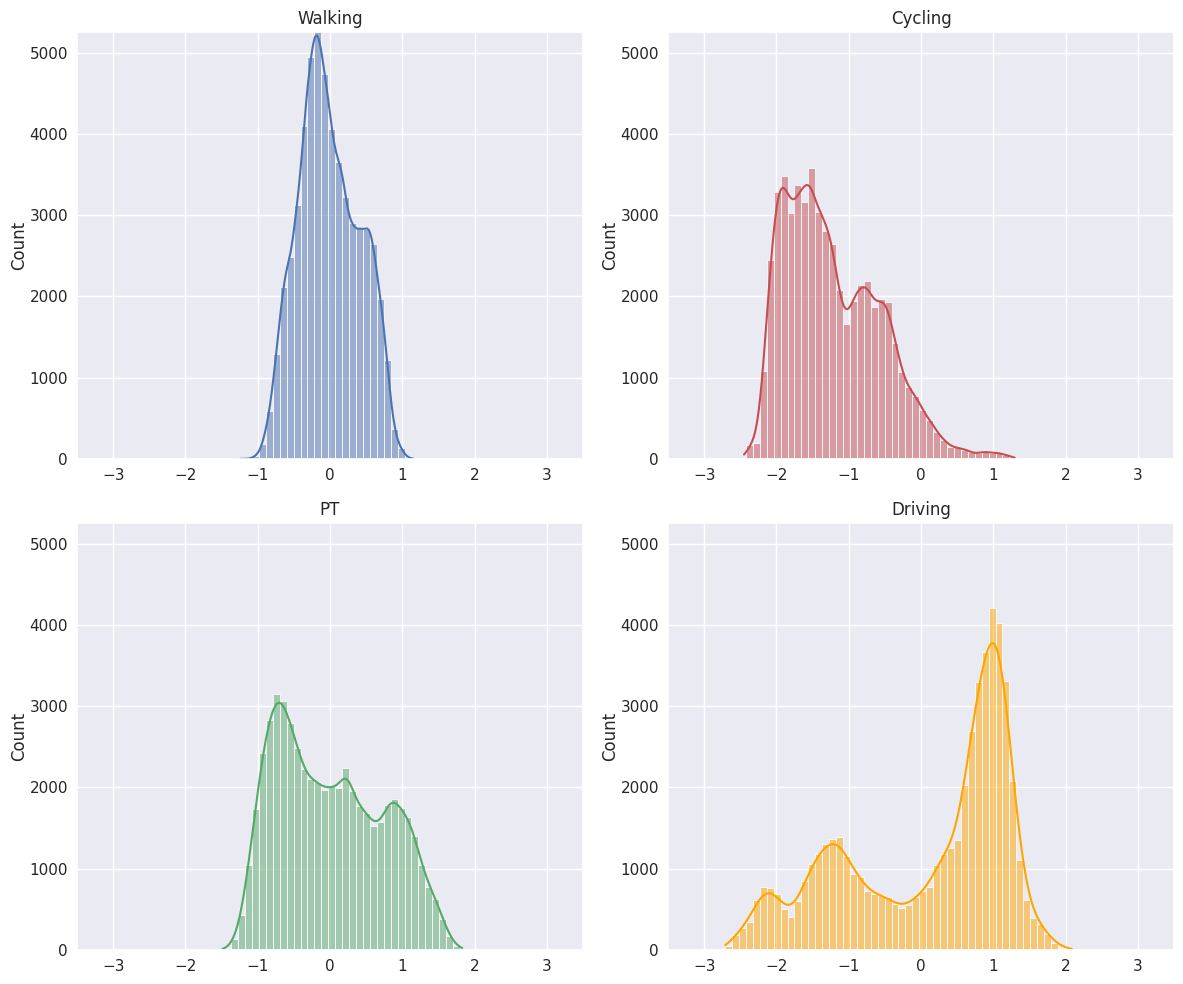

In [13]:
plot_ind_spec_constant(socec_model, lgb_train_set, ['Walking', 'Cycling', 'PT', 'Driving'])

# References

Salvadé, N., & Hillel, T. (2024). Rumboost: Gradient Boosted Random Utility Models. *arXiv preprint [arXiv:2401.11954](https://arxiv.org/abs/2401.11954)*

Hillel, T., Elshafie, M.Z.E.B., Jin, Y., 2018. Recreating passenger mode choice-sets for transport simulation: A case study of London, UK. Proceedings of the Institution of Civil Engineers - Smart Infrastructure and Construction 171, 29–42. https://doi.org/10.1680/jsmic.17.00018